In [2]:
import duckdb

with duckdb.connect("data/sakila.duckdb") as conn:
    description = conn.sql("DESC;").df()

dfs = {}

with duckdb.connect("data/sakila.duckdb") as conn:
    for name in description["name"]:
        if name[0] != "_":
            dfs[name] = conn.sql(f"FROM staging.{name};").df()
            duckdb.register(name, dfs[name])

TASK 1

In [3]:
# a)

a = duckdb.sql("SELECT title,length FROM film WHERE length > 180;").df()
a.head()

,title,length
0,ANALYZE HOOSIERS,181
1,BAKED CLEOPATRA,182
2,CATCH AMISTAD,183
3,CHICAGO NORTH,185
4,CONSPIRACY SPIRIT,184


In [4]:
# b)

b = duckdb.sql("select title, rating, length, description from film where regexp_matches(title, '(^| )LOVE($| )');").df()
b

,title,rating,length,description
0,GRAFFITI LOVE,PG,117,A Unbelieveable Epistle of a Sumo Wrestler And...
1,IDAHO LOVE,PG-13,172,A Fast-Paced Drama of a Student And a Crocodil...
2,INDIAN LOVE,NC-17,135,A Insightful Saga of a Mad Scientist And a Mad...
3,LAWRENCE LOVE,NC-17,175,A Fanciful Yarn of a Database Administrator An...
4,LOVE SUICIDES,R,181,A Brilliant Panorama of a Hunter And a Explore...


In [5]:
# c)
c = duckdb.sql("SELECT MIN(length), MAX(length), AVG(length), MEDIAN(length) FROM film;").df()
c

,min(length),max(length),avg(length),median(length)
0,46,185,115.272,114.0


In [6]:
# d)
d = duckdb.sql("SELECT title, rental_rate/rental_duration AS ppd FROM film ORDER BY ppd DESC LIMIT 10;").df()
d

,title,ppd
0,AMERICAN CIRCUS,1.663333
1,BACKLASH UNDEFEATED,1.663333
2,BILKO ANONYMOUS,1.663333
3,BEAST HUNCHBACK,1.663333
4,CARIBBEAN LIBERTY,1.663333
5,AUTUMN CROW,1.663333
6,CASPER DRAGONFLY,1.663333
7,ACE GOLDFINGER,1.663333
8,BEHAVIOR RUNAWAY,1.663333
9,CASUALTIES ENCINO,1.663333


In [48]:
# e)
e = duckdb.sql("SELECT fa.actor_id,a.first_name,a.last_name,COUNT(fa.film_id) AS frequency FROM actor a LEFT JOIN film_actor fa ON a.actor_id = fa.actor_id GROUP BY fa.actor_id,a.first_name,a.last_name ORDER BY frequency LIMIT 10;")
e

┌──────────┬────────────┬───────────┬───────────┐
│ actor_id │ first_name │ last_name │ frequency │
│  int64   │  varchar   │  varchar  │   int64   │
├──────────┼────────────┼───────────┼───────────┤
│      148 │ EMILY      │ DEE       │        14 │
│      199 │ JULIA      │ FAWCETT   │        15 │
│       35 │ JUDY       │ DEAN      │        15 │
│      186 │ JULIA      │ ZELLWEGER │        16 │
│       71 │ ADAM       │ GRANT     │        18 │
│       31 │ SISSY      │ SOBIESKI  │        18 │
│        1 │ PENELOPE   │ GUINESS   │        19 │
│       30 │ SANDRA     │ PECK      │        19 │
│       63 │ CAMERON    │ WRAY      │        19 │
│      183 │ RUSSELL    │ CLOSE     │        19 │
├──────────┴────────────┴───────────┴───────────┤
│ 10 rows                             4 columns │
└───────────────────────────────────────────────┘

TASK 2

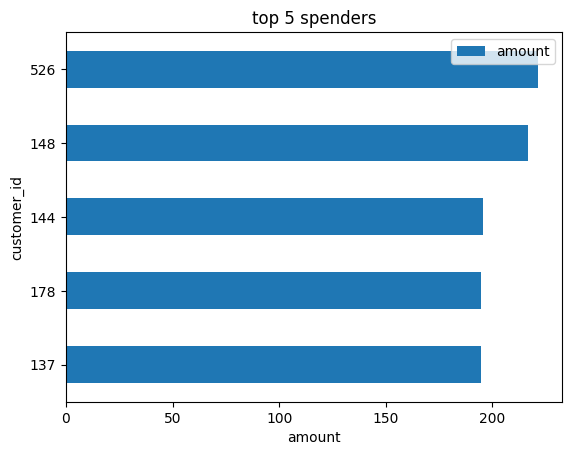

In [8]:
# a)
top_spender = duckdb.sql("""SELECT customer_id,SUM(amount) AS amount FROM payment GROUP BY customer_id ORDER BY amount DESC;""").df()
ax = top_spender.head(5).plot(
    kind="barh",
    x="customer_id",
    y="amount",
    title="top 5 spenders",
    xlabel="amount",
)
ax.invert_yaxis()

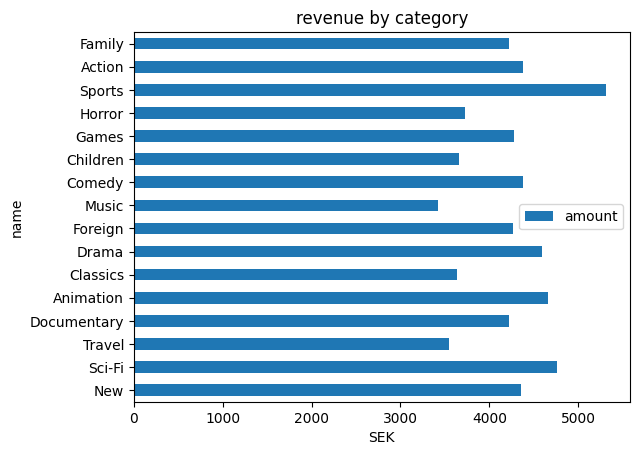

In [53]:
# b)
revenue_category = duckdb.sql("""SELECT
c.name,
SUM(p.amount) AS amount 
FROM category c
LEFT JOIN film_category fc ON c.category_id = fc.category_id
LEFT JOIN film f ON fc.film_id = f.film_id
LEFT JOIN inventory i ON f.film_id = i.film_id
LEFT JOIN rental r ON i.inventory_id = r.inventory_id
LEFT JOIN payment p ON r.rental_id = p.rental_id
GROUP BY c.name;""").df()

ax = revenue_category.plot(
    kind="barh",
    x="name",
    y="amount",
    title="revenue by category",
    xlabel="SEK",
)
ax.invert_yaxis()